# Machine Learning Engineer Nanodegree
## Capstone
## Project- Corn Commodity Futures Price Predictor

In this project we will try to predict closing weekly price of Corn Commodity Futures. In order to perform this prediction we will create a dataset that includes weekly Corn Futures closing prices as well as Long Open Interest and Short Open Interest of Processors/Users( sometimes they are called Commercials) from COT reports and by using this dataset we will try to predict next week’s prices. 


## 1. Data Sets

Historical Futures Prices: Corn Futures, Continuous Contract #1. Non-adjusted price based on spot-month continuous contract calculations. Raw data from CME:
[Can be found here](https://www.quandl.com/data/CHRIS/CME_C1-Corn-Futures-Continuous-Contract-1-C1-Front-Month)<br>
Commitment of Traders - CORN (CBT) - Futures Only (002602)
[Can be found here](https://www.quandl.com/data/CFTC/002602_F_ALL-Commitment-of-Traders-CORN-CBT-Futures-Only-002602)

Data has been downloaded and stored in \Data folder:

- **.\data\CHRIS-CME_C1.csv** - Corn Futures Prices data
- **.\data\CFTC-002602_F_ALL.csv** - Commitment of Traders data


In [118]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
pd.options.display.max_colwidth = 500  # You need this, otherwise pandas
# will limit your HTML strings to 50 characters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

## 2. Data Exploration



In [45]:
df_fut_orig = pd.read_csv('data\CHRIS-CME_C1.csv')
df_fut_orig.head(n=5)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous_Day_Open_Interest
0,2018-07-10,344.25,344.75,336.25,339.50,6.00,339.75,2668.0,2186.0
1,2018-07-09,346.00,348.50,342.50,346.00,6.00,345.75,3190.0,2969.0
2,2018-07-06,342.00,352.25,342.00,350.75,8.25,351.75,3068.0,3959.0
3,2018-07-05,345.50,348.75,341.50,342.50,0.75,343.50,3302.0,4812.0
4,2018-07-03,340.25,345.25,339.25,343.25,5.25,342.75,3048.0,5687.0


In [46]:
# Display a description of the dataset
display(df_fut_orig.describe())

,Open,High,Low,Last,Change,Settle,Volume,Previous_Day_Open_Interest
count,3033.000000,3034.000000,3034.000000,3034.000000,1081.000000,3034.000000,3034.000000,3034.00000
mean,457.095038,462.322924,451.795485,456.920040,3.950324,456.979318,103905.200396,352140.90145
std,140.338892,142.056030,138.436196,140.243019,3.415126,140.204571,73993.219920,248565.85531
min,219.000000,220.750000,216.750000,219.000000,0.000000,219.000000,0.000000,107.00000
25%,360.000000,363.000000,356.250000,359.500000,1.500000,359.750000,40172.750000,107559.25000
50%,388.500000,392.000000,383.500000,388.750000,3.000000,389.000000,102567.000000,365073.00000
75%,565.500000,573.562500,557.375000,564.625000,5.500000,564.625000,152391.250000,556408.50000
max,830.250000,843.750000,822.750000,831.250000,30.750000,831.250000,538170.000000,858696.00000


Seems there are some rows where Volume=0, lets find out more about these rows

In [47]:
df_fut_orig[df_fut_orig['Volume']<1]

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous_Day_Open_Interest
823,2015-04-03,386.50,386.50,386.50,386.50,NaN,386.50,0.0,470964.0
1577,2012-04-06,658.25,658.25,658.25,658.25,NaN,658.25,0.0,401521.0
2831,2007-04-05,359.75,367.50,357.25,366.00,NaN,366.00,0.0,354349.0


Since we will resample daily prices into weekly prices , lets drop those rows. 

In [48]:
# drop outliers
df_fut_orig.drop(df_fut_orig[df_fut_orig.Volume<1].index, inplace=True)

In [49]:
df_cot_orig = pd.read_csv('data\CFTC-002602_F_ALL.csv')
display(df_cot_orig.head())

,Date,Open_Interest,Producer_Merchant_Processor_User_Longs,Producer_Merchant_Processor_User_Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
0,2018-07-10,1818055.0,500172.0,750062.0,208128.0,39513.0,99477.0,263353.0,404297.0,154286.0,320946.0,70682.0,98709.0,1645071.0,1617026.0,172984.0,201029.0
1,2018-07-03,1830330.0,484257.0,773851.0,210341.0,36927.0,100340.0,274795.0,382191.0,149756.0,322256.0,66508.0,119627.0,1661372.0,1629200.0,168958.0,201130.0
2,2018-06-26,1885804.0,513100.0,840177.0,223131.0,32763.0,91972.0,287061.0,377825.0,153461.0,330396.0,58283.0,116745.0,1715866.0,1671226.0,169938.0,214578.0
3,2018-06-19,1992169.0,525197.0,920764.0,222105.0,41144.0,99285.0,299377.0,356828.0,163454.0,379025.0,56652.0,135078.0,1823521.0,1773205.0,168648.0,218964.0
4,2018-06-12,1963233.0,488666.0,917204.0,235249.0,37674.0,93281.0,292054.0,304292.0,172623.0,363918.0,65030.0,147098.0,1792889.0,1737202.0,170344.0,226031.0


In [50]:
display(df_cot_orig.describe())

,Open_Interest,Producer_Merchant_Processor_User_Longs,Producer_Merchant_Processor_User_Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
count,6.310000e+02,631.000000,6.310000e+02,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,6.310000e+02,6.310000e+02,631.000000,631.000000
mean,1.292201e+06,270795.049128,6.268425e+05,290792.497623,20337.034865,33260.068146,236884.269414,137472.426307,94546.356577,140931.890650,70914.334390,85505.109350,1.152715e+06,1.068878e+06,139485.541997,223322.976228
std,2.095471e+05,68976.221600,1.554272e+05,53203.484072,18944.008732,22912.567257,67454.195123,109465.025186,32739.133163,51939.690903,26360.863384,29682.425476,1.939790e+05,2.060080e+05,23718.957966,29824.710288
min,7.482520e+05,102373.000000,2.972960e+05,186981.000000,0.000000,4397.000000,96989.000000,6714.000000,29130.000000,49809.000000,25905.000000,27592.000000,6.379810e+05,5.689510e+05,78578.000000,156086.000000
25%,1.192226e+06,226595.000000,5.235930e+05,255196.500000,6524.000000,13978.000000,186366.500000,47947.000000,72018.500000,104764.000000,53331.000000,62690.000000,1.055362e+06,9.573815e+05,121829.500000,198860.500000
50%,1.301506e+06,262823.000000,6.112810e+05,276337.000000,15239.000000,27209.000000,225682.000000,95548.000000,91850.000000,140343.000000,66261.000000,82705.000000,1.166372e+06,1.067548e+06,136966.000000,227337.000000
75%,1.398275e+06,314224.000000,7.058555e+05,321265.500000,28178.000000,48009.500000,287331.000000,211154.000000,113803.000000,175846.000000,83448.500000,106077.500000,1.247976e+06,1.180280e+06,153542.500000,246903.000000
max,1.992169e+06,525197.000000,1.001517e+06,422803.000000,95591.000000,113775.000000,431569.000000,447470.000000,231064.000000,379025.000000,173322.000000,181385.000000,1.825238e+06,1.773205e+06,206821.000000,293948.000000


### Drop unnecessary columns columns and resample data

In [51]:
df_fut=df_fut_orig.drop(columns=[clmn for i,clmn in enumerate(df_fut_orig.columns) if i not in [0,6,7] ],axis=1)

df_fut['Date'] = pd.to_datetime(df_fut['Date'])
df_fut.set_index('Date',inplace=True)

display(df_fut.head())

,Settle,Volume
Date,,
2018-07-10,339.75,2668.0
2018-07-09,345.75,3190.0
2018-07-06,351.75,3068.0
2018-07-05,343.50,3302.0
2018-07-03,342.75,3048.0


In [52]:
s_settle =df_fut['Settle'].resample('W').last()
s_volume =df_fut['Volume'].resample('W').last()
df_fut_weekly = pd.concat([s_settle,s_volume], axis=1)
display(df_fut_weekly.head())

,Settle,Volume
Date,,
2006-06-18,235.50,56486.0
2006-06-25,228.25,28361.0
2006-07-02,235.50,30519.0
2006-07-09,241.00,13057.0
2006-07-16,253.50,2460.0


In [53]:
df_cot=df_cot_orig.drop(columns=[clmn for i,clmn in enumerate(df_cot_orig.columns) if i not in [0,1,2,3 ]],axis=1)
df_cot.rename(index=str, columns={"Producer_Merchant_Processor_User_Longs": "Longs", \
                                  "Producer_Merchant_Processor_User_Shorts": "Shorts"},inplace=True)
df_cot['Date'] = pd.to_datetime(df_cot['Date'])
df_cot.set_index('Date',inplace=True)
display(df_cot.head())

,Open_Interest,Longs,Shorts
Date,,,
2018-07-10,1818055.0,500172.0,750062.0
2018-07-03,1830330.0,484257.0,773851.0
2018-06-26,1885804.0,513100.0,840177.0
2018-06-19,1992169.0,525197.0,920764.0
2018-06-12,1963233.0,488666.0,917204.0


In [85]:
s_longs =df_cot['Longs'].resample('W').last()
s_shorts =df_cot['Shorts'].resample('W').last()
s_open_interest =df_cot['Open_Interest'].resample('W').last()
df_cot_weekly = pd.concat([s_open_interest,s_longs, s_shorts], axis=1)
display(df_cot_weekly.head(5))

,Open_Interest,Longs,Shorts
Date,,,
2006-06-18,1320155.0,209662.0,699163.0
2006-06-25,1321520.0,224476.0,666688.0
2006-07-02,1329400.0,234769.0,645735.0
2006-07-09,1327482.0,220552.0,648405.0
2006-07-16,1333225.0,216968.0,673110.0


In [86]:
df_weekly = pd.merge(df_fut_weekly,df_cot_weekly, on='Date')
display(df_weekly.head(5))


,Settle,Volume,Open_Interest,Longs,Shorts
Date,,,,,
2006-06-18,235.50,56486.0,1320155.0,209662.0,699163.0
2006-06-25,228.25,28361.0,1321520.0,224476.0,666688.0
2006-07-02,235.50,30519.0,1329400.0,234769.0,645735.0
2006-07-09,241.00,13057.0,1327482.0,220552.0,648405.0
2006-07-16,253.50,2460.0,1333225.0,216968.0,673110.0


In [56]:
# Display a description of the dataset
display(df_weekly.describe())

,Settle,Volume,Open_Interest,Longs,Shorts
count,631.000000,631.000000,6.310000e+02,631.000000,6.310000e+02
mean,456.978605,100835.204437,1.292201e+06,270795.049128,6.268425e+05
std,140.242112,72466.341538,2.095471e+05,68976.221600,1.554272e+05
min,219.750000,132.000000,7.482520e+05,102373.000000,2.972960e+05
25%,359.500000,34822.500000,1.192226e+06,226595.000000,5.235930e+05
50%,389.250000,101209.000000,1.301506e+06,262823.000000,6.112810e+05
75%,560.375000,150341.000000,1.398275e+06,314224.000000,7.058555e+05
max,824.500000,369522.000000,1.992169e+06,525197.000000,1.001517e+06


**Step 2: ** Visualise raw data.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


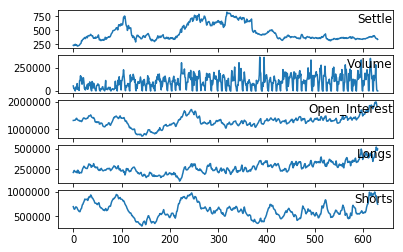

In [57]:
%load_ext autoreload
%autoreload 2

import visuals

visuals.plot_numerical_series(df_weekly)

**Step 3 :** Normalise the data using minmaxscaler function

In [127]:
# rest index since we need row numbers for splitting
df_weekly.reset_index(inplace=True)

In [128]:
validation_start=df_weekly[df_weekly['Date'] >= pd.to_datetime('2016-01-01')].index[0]
testing_start=df_weekly[df_weekly['Date'] >= pd.to_datetime('2018-01-01')].index[0]

In [129]:
print("validation start",validation_start)
print("testing start",testing_start)

validation start 498
testing start 603


In [130]:
# print data to double check
#print(df_weekly.iloc[validation_start])
#print(df_weekly.iloc[testing_start])

In [131]:
scaler = MinMaxScaler(feature_range=(0, 1))
values = df_weekly.loc[:, df_weekly.columns != 'Date'].values
scaled = scaler.fit_transform(values)


In [132]:
%load_ext autoreload
%autoreload 2
import data_preparer
reframed = data_preparer.series_to_supervised(scaled, 1, 1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)

In [134]:
display(reframed.head())

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.026044,0.152560,0.459760,0.253744,0.570655,0.014055
2,0.014055,0.076421,0.460857,0.288780,0.524540,0.026044
3,0.026044,0.082263,0.467192,0.313123,0.494786,0.035138
4,0.035138,0.034990,0.465650,0.279499,0.498578,0.055808
5,0.055808,0.006302,0.470267,0.271023,0.533659,0.028938


### Define and Fit Model

In [135]:
# split into train and validation sets
values = reframed.values
train = values[:validation_start, :]
validation = values[validation_start:testing_start, :]
test = values[testing_start:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
validation_X, validation_y = validation[:, :-1], validation[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape,test_X.shape, test_y.shape)

(498, 1, 5) (498,) (105, 1, 5) (105,) (27, 1, 5) (27,)


Train on 498 samples, validate on 105 samples
Epoch 1/500
 - 2s - loss: 0.3985 - val_loss: 0.1671
Epoch 2/500
 - 0s - loss: 0.3473 - val_loss: 0.1115
Epoch 3/500
 - 0s - loss: 0.2955 - val_loss: 0.0546
Epoch 4/500
 - 0s - loss: 0.2417 - val_loss: 0.0284
Epoch 5/500
 - 0s - loss: 0.1953 - val_loss: 0.0703
Epoch 6/500
 - 0s - loss: 0.1696 - val_loss: 0.1167
Epoch 7/500
 - 0s - loss: 0.1596 - val_loss: 0.1475
Epoch 8/500
 - 0s - loss: 0.1550 - val_loss: 0.1663
Epoch 9/500
 - 0s - loss: 0.1523 - val_loss: 0.1768
Epoch 10/500
 - 0s - loss: 0.1501 - val_loss: 0.1814
Epoch 11/500
 - 0s - loss: 0.1482 - val_loss: 0.1816
Epoch 12/500
 - 0s - loss: 0.1462 - val_loss: 0.1792
Epoch 13/500
 - 0s - loss: 0.1442 - val_loss: 0.1757
Epoch 14/500
 - 0s - loss: 0.1422 - val_loss: 0.1720
Epoch 15/500
 - 0s - loss: 0.1401 - val_loss: 0.1684
Epoch 16/500
 - 0s - loss: 0.1380 - val_loss: 0.1653
Epoch 17/500
 - 0s - loss: 0.1359 - val_loss: 0.1627
Epoch 18/500
 - 0s - loss: 0.1338 - val_loss: 0.1601
Epoch 19/

Epoch 154/500
 - 0s - loss: 0.0274 - val_loss: 0.0131
Epoch 155/500
 - 0s - loss: 0.0275 - val_loss: 0.0134
Epoch 156/500
 - 0s - loss: 0.0274 - val_loss: 0.0132
Epoch 157/500
 - 0s - loss: 0.0274 - val_loss: 0.0133
Epoch 158/500
 - 0s - loss: 0.0274 - val_loss: 0.0133
Epoch 159/500
 - 0s - loss: 0.0274 - val_loss: 0.0133
Epoch 160/500
 - 0s - loss: 0.0273 - val_loss: 0.0133
Epoch 161/500
 - 0s - loss: 0.0274 - val_loss: 0.0133
Epoch 162/500
 - 0s - loss: 0.0274 - val_loss: 0.0131
Epoch 163/500
 - 0s - loss: 0.0275 - val_loss: 0.0133
Epoch 164/500
 - 0s - loss: 0.0274 - val_loss: 0.0131
Epoch 165/500
 - 0s - loss: 0.0274 - val_loss: 0.0133
Epoch 166/500
 - 0s - loss: 0.0273 - val_loss: 0.0131
Epoch 167/500
 - 0s - loss: 0.0274 - val_loss: 0.0133
Epoch 168/500
 - 0s - loss: 0.0273 - val_loss: 0.0131
Epoch 169/500
 - 0s - loss: 0.0273 - val_loss: 0.0133
Epoch 170/500
 - 0s - loss: 0.0273 - val_loss: 0.0132
Epoch 171/500
 - 0s - loss: 0.0273 - val_loss: 0.0133
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.0265 - val_loss: 0.0139
Epoch 307/500
 - 0s - loss: 0.0265 - val_loss: 0.0139
Epoch 308/500
 - 0s - loss: 0.0265 - val_loss: 0.0140
Epoch 309/500
 - 0s - loss: 0.0265 - val_loss: 0.0140
Epoch 310/500
 - 0s - loss: 0.0265 - val_loss: 0.0138
Epoch 311/500
 - 0s - loss: 0.0265 - val_loss: 0.0141
Epoch 312/500
 - 0s - loss: 0.0265 - val_loss: 0.0143
Epoch 313/500
 - 0s - loss: 0.0265 - val_loss: 0.0139
Epoch 314/500
 - 0s - loss: 0.0265 - val_loss: 0.0140
Epoch 315/500
 - 0s - loss: 0.0265 - val_loss: 0.0142
Epoch 316/500
 - 0s - loss: 0.0265 - val_loss: 0.0141
Epoch 317/500
 - 0s - loss: 0.0265 - val_loss: 0.0141
Epoch 318/500
 - 0s - loss: 0.0265 - val_loss: 0.0139
Epoch 319/500
 - 0s - loss: 0.0265 - val_loss: 0.0146
Epoch 320/500
 - 0s - loss: 0.0265 - val_loss: 0.0144
Epoch 321/500
 - 0s - loss: 0.0265 - val_loss: 0.0141
Epoch 322/500
 - 0s - loss: 0.0264 - val_loss: 0.0141
Epoch 323/500
 - 0s - loss: 0.0265 - val_loss: 0.0139
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.0264 - val_loss: 0.0157
Epoch 459/500
 - 0s - loss: 0.0263 - val_loss: 0.0148
Epoch 460/500
 - 0s - loss: 0.0264 - val_loss: 0.0141
Epoch 461/500
 - 0s - loss: 0.0263 - val_loss: 0.0149
Epoch 462/500
 - 0s - loss: 0.0263 - val_loss: 0.0155
Epoch 463/500
 - 0s - loss: 0.0263 - val_loss: 0.0143
Epoch 464/500
 - 0s - loss: 0.0264 - val_loss: 0.0145
Epoch 465/500
 - 0s - loss: 0.0263 - val_loss: 0.0158
Epoch 466/500
 - 0s - loss: 0.0264 - val_loss: 0.0156
Epoch 467/500
 - 0s - loss: 0.0264 - val_loss: 0.0140
Epoch 468/500
 - 0s - loss: 0.0264 - val_loss: 0.0144
Epoch 469/500
 - 0s - loss: 0.0264 - val_loss: 0.0162
Epoch 470/500
 - 0s - loss: 0.0265 - val_loss: 0.0159
Epoch 471/500
 - 0s - loss: 0.0266 - val_loss: 0.0136
Epoch 472/500
 - 0s - loss: 0.0265 - val_loss: 0.0146
Epoch 473/500
 - 0s - loss: 0.0264 - val_loss: 0.0166
Epoch 474/500
 - 0s - loss: 0.0266 - val_loss: 0.0158
Epoch 475/500
 - 0s - loss: 0.0268 - val_loss: 0.0134
Epoch 476/500
 - 0s - loss: 

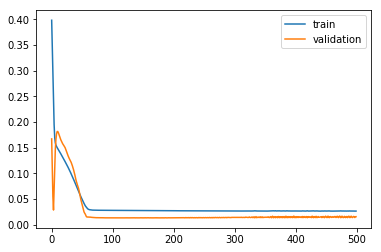

In [136]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(validation_X, validation_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

**Step 4 :** Visualize the data again

In [137]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 9.552


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


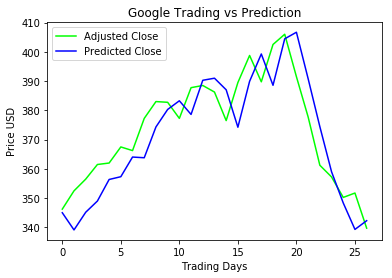

In [138]:
%load_ext autoreload
%autoreload 2
import visuals

visuals.plot_lstm_prediction(inv_y,inv_yhat)

**Step 5:** Log the normalised data for future resuablilty

In [139]:
stocks.to_csv('google_preprocessed.csv',index= False)

NameError: name 'stocks' is not defined

# Check Point #2

This is my second checkpoint. The preprocessed data has been saved to disk.

## Bench Mark Model

In this section we will check our bench mark model. As is proposed in my proposal my bench mark model is a simple linear regressor model. 

**Step 1:** Load the preprocessed data

In [ ]:
import math
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import visualize as vs
import stock_data as sd
import LinearRegressionModel

stocks = pd.read_csv('google_preprocessed.csv')
display(stocks.head())

**Step 2:** Split data into train and test pair

In [ ]:
X_train, X_test, y_train, y_test, label_range= sd.train_test_split_linear_regression(stocks)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

**Step 3:** Train a Linear regressor model on training set and get prediction

In [ ]:
model = LinearRegressionModel.build_model(X_train,y_train)

**Step 4:** Get prediction on test set

In [ ]:
predictions = LinearRegressionModel.predict_prices(model,X_test, label_range)

**Step 5:** Plot the predicted values against actual

In [ ]:
vs.plot_prediction(y_test,predictions)

**Step 6:** measure accuracy of the prediction

In [ ]:
trainScore = mean_squared_error(X_train, y_train)
print('Train Score: %.4f MSE (%.4f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = mean_squared_error(predictions, y_test)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

# Checkpoint #3


## Long-Sort Term Memory Model

In this section we will use LSTM to train and test on our data set.

### Basic LSTM Model

First lets make a basic LSTM model.

**Step 1 :** import keras libraries for smooth implementaion of lstm 

In [ ]:
import math
import pandas as pd
import numpy as np
from IPython.display import display

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import lstm, time #helper libraries

import visualize as vs
import stock_data as sd
import LinearRegressionModel

stocks = pd.read_csv('google_preprocessed.csv')
stocks_data = stocks.drop(['Item'], axis =1)

display(stocks_data.head())

**Step 2 :** Split train and test data sets and Unroll train and test data for lstm model

In [ ]:
X_train, X_test,y_train, y_test = sd.train_test_split_lstm(stocks_data, 5)

unroll_length = 50
X_train = sd.unroll(X_train, unroll_length)
X_test = sd.unroll(X_test, unroll_length)
y_train = y_train[-X_train.shape[0]:]
y_test = y_test[-X_test.shape[0]:]

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

**Step 3 :** Build a basic Long-Short Term Memory model

In [ ]:
# build basic lstm model
model = lstm.build_basic_model(input_dim = X_train.shape[-1],output_dim = unroll_length, return_sequences=True)

# Compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)

**Step 4:** Train the model

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_split=0.05)

**Step 5:** make prediction using test data

In [ ]:
predictions = model.predict(X_test)

**Step 6:** Plot the results

In [ ]:
vs.plot_lstm_prediction(y_test,predictions)

** Step 7:** Get the test score.

In [ ]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

### Improved LSTM Model

**Step 1: ** Build an improved LSTM model

In [ ]:
# Set up hyperparameters
batch_size = 100
epochs = 5

# build improved lstm model
model = lstm.build_improved_model( X_train.shape[-1],output_dim = unroll_length, return_sequences=True)

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)

**Step 2: ** Train improved LSTM model

In [ ]:
model.fit(X_train, 
          y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.05
         )

**Step 3:** Make prediction on improved LSTM model

In [ ]:
# Generate predictions 
predictions = model.predict(X_test, batch_size=batch_size)

**Step 4:** plot the results

In [ ]:
vs.plot_lstm_prediction(y_test,predictions)

**Step 5:** Get the test score

In [ ]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

In [ ]:
range = [np.amin(stocks_data['Close']), np.amax(stocks_data['Close'])]

#Calculate the stock price delta in $

true_delta = testScore*(range[1]-range[0])
print('Delta Price: %.6f - RMSE * Adjusted Close Range' % true_delta)    

# Checking Robustness of the model

In this section we will check robustness of our LSTM model. I have used new unseen datasets for this from July 1, 2017 to July 20,2017. I have downloaded the data sets from google finance website to check for robustness of the model.

In [ ]:
import preprocess_data as ppd

data = pd.read_csv('googl.csv')

stocks = ppd.remove_data(data)

stocks = ppd.get_normalised_data(stocks)

stocks = stocks.drop(['Item'], axis = 1)
#Print the dataframe head and tail
print(stocks.head())

X = stocks[:].as_matrix()
Y = stocks[:]['Close'].as_matrix()

X = sd.unroll(X,1)
Y = Y[-X.shape[0]:]

print(X.shape)
print(Y.shape)

# Generate predictions 
predictions = model.predict(X)

#get the test score
testScore = model.evaluate(X, Y, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))